# Train image classifiers with Pytorch Lightning
- Baseline training: 5 models (Timm, ImageNet pretrained weights from huggingface)
- Ensemble and finetuning
   - Round1: Finetune 3 models from baseline.
   - Round2: Finetune 3 models and train 2 more models.
   - Final: Grid search for best weights to maximize score on cross-validation.
- Modify REPORT_TO variable below to "none" if you don't want to use wandb to follow the training metrics.

In [1]:
import sys
sys.path.append("../code/src")
import cdc
from cdc.common.utils import *
from cdc.common.constants import *
from cdc.common.metrics import *
from cdc.models.pl.classifier import *
from cdc.models.pl.dataset import *
from cdc.utils.imaging import *
from cdc.script.inferv1 import *
from cdc.script.trainv1 import *
from cdc.script.utils import *
from cdc.yolo.tools import *
from cdc.yolo.inference import *
from cdc.utils.imaging import *

/home/mpware/miniconda3/envs/ml310/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import glob, os, time, random, gc, sys, math, re
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import OrderedDict
import shutil
from tqdm import tqdm
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.8) 
import PIL
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score
import wandb
import albumentations as A
from albumentations.pytorch import ToTensorV2
from huggingface_hub import login

In [3]:
print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("Torch", torch.__version__)
print("Lightning", L.__version__)
print("Albumentations", A.__version__)
print("CDC", cdc.__version__)

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy 1.26.4
Pandas 2.2.2
Torch 2.5.1+cu124
Lightning 2.4.0
Albumentations 1.4.22
CDC 1.0.0


In [4]:
DATA_HOME = "../data"
IMAGES_HOME = os.path.join(DATA_HOME, "images_cytologia")
MODELS_HOME = "../models/RGB"
CONFIG_HOME = "../code"

MARGINS = 16
ROOT = "yolox_s"

TRAIN_FILE = os.path.join(DATA_HOME, "cv4_seed42_multilabel.parquet")
BACKGROUND_HOME = os.path.join(DATA_HOME, "background")
BACKGROUND_FILE = os.path.join(DATA_HOME, "cv4_seed42_background.parquet")
BOXES_HOME = os.path.join(DATA_HOME, "boxes", "%s_640_v3.2.0_0.0010_0.300_0.250_full_m%d_seed42_train_cleaned" % (ROOT, MARGINS))
BOXES_TEST_HOME = os.path.join(DATA_HOME, "boxes", "%s_640_v3.2.0_0.0010_0.300_0.250_full_m%d_seed42_test_cleaned" % (ROOT, MARGINS))
TEST_FILE = os.path.join(DATA_HOME, "test.csv")
TEST_YOLOX31_RAW_FILE = os.path.join(DATA_HOME, "test_raw_yolox_s_512_v3.1.parquet") # Yolox3.1 prediction before WBF
BOXES_TEST_YOLOX31_HOME = os.path.join(DATA_HOME, "boxes", "%s_512_v3.1_0.0010_0.300_0.250_full_m%d_seed42_test_cleaned" % (ROOT, MARGINS)) # Yolox3.1 prediction after WBF / cleaning

SEEDS = [42]
seed_everything_now(SEEDS[0])
seed_everything(SEEDS[0], workers=True)
torch.set_float32_matmul_precision('high')

INFERENCE_NAME = "_inference_yoloxv3.1_5models"
REPORT_TO = "wandb" # "none"

# Hugging face token if needed
# login(token = "YOURHFTOKENHEREFORTIMMIMAGENETPRETRAINEDWEIGHTS")

Seed set to 42


In [ ]:
# Copy background images to boxes folder. It takes a few minutes
os.makedirs(os.path.join(BOXES_HOME, "background"), exist_ok=True)
shutil.copytree(BACKGROUND_HOME, os.path.join(BOXES_HOME, "background"), dirs_exist_ok = True)

## Training : Baseline (5 models)
Run them one by one (restart notebook) if you get GPU memory issues.

In [5]:
pd.read_parquet(TRAIN_FILE).head()

,filename,NAME,src,img_width,img_height,phash,mean,std,img_surface,bb_avg_surface_ratio,...,LH_lyAct,LM,LZMG,SS,multilabel,surface_bin,bb_avg_surface_ratio_bin,mean_bin,std_bin,fold_s42
0,images_cytologia/00008cef-c.jpg,00008cef-c.jpg,train,368,370,b787daa066b8d247,209.093224,42.264992,136160,16.521739,...,0,0,0,0,0,0,1,4,2,1
1,images_cytologia/00010aae-3.jpg,00010aae-3.jpg,train,352,357,b4b0c86c26fe0f1f,186.580450,48.086801,125664,24.112713,...,0,0,0,0,3,0,1,2,2,0
2,images_cytologia/00016779-d.jpg,00016779-d.jpg,train,352,357,e9ca8c4c60943fbf,188.245209,47.232337,125664,18.382353,...,0,0,0,0,3,0,1,3,2,0
3,images_cytologia/0003ab57-1.jpg,0003ab57-1.jpg,train,368,369,f6c4d95d63ec8419,198.827933,44.390070,135792,16.235124,...,0,0,0,0,0,0,1,3,2,0
4,images_cytologia/000a7dc3-d.jpg,000a7dc3-d.jpg,train,368,369,a7168d7522a59f9c,204.639925,45.881671,135792,7.586603,...,0,0,0,0,10,0,0,3,2,2


##### Multi-classes/boxes : timm_vit_large_patch16 with image size = 224, TTA: Horizontal flip (32 epochs, batch size=32)

In [ ]:
# Training time: Around 20h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_vitl_224_1.2.4.json"), BOXES_HOME, BOXES_HOME + ".parquet", TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

##### Multi-classes/boxes : timm_vit_large_patch16 with image size = 224 and background, TTA: Horizontal flip (32 epochs, batch size=32)

In [ ]:
# Training time: Around 20h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_vitl_224_bg_1.2.5.json"), BOXES_HOME, BOXES_HOME + ".parquet", TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=BACKGROUND_HOME, background_file=BACKGROUND_FILE, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

##### Multi-classes/boxes : timm_nextvit_large with image size = 384, TTA: Horizontal flip (32 epochs, batch size=32)

In [ ]:
# Training time: Around 20h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_nextvit_384_1.2.4.json"), BOXES_HOME, BOXES_HOME + ".parquet", TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

##### Multi-classes/boxes : timm_tf_efficientnetv2_m with image size = 512, TTA: Horizontal flip (32 epochs, batch size=32)

In [ ]:
# Training time: Around 24h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_effnetv2m_512_1.2.4.json"), BOXES_HOME, BOXES_HOME + ".parquet", TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

##### Multi-labels/Full images: timm_tf_efficientnetv2_m with image size = 512, No TTA  (32 epochs, batch size=32)

In [ ]:
# Training time: Around 24h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "ml_effnetv2m_512_bg_1.3.0.json"), DATA_HOME, TRAIN_FILE, TEST_FILE, None, None, light_augmentation_train,
                background_home=BACKGROUND_HOME, background_file=BACKGROUND_FILE, tta=None, tta_name="_notta", train_epochs=32, report_to=REPORT_TO)

## Perform models ensembling

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# CV=0.9250, LB=0.93527 (argmax)
MODELS_DICT = {

    # Multiclasses models
    'cnn_and_transformers-bb-multiclass': {
        # CV=0.9153
        'root_dir_mc_512/0.3333': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.2.4-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9102, LB(HFlip)=0.9281 - 20min
        ],
        # CV=0.9110
        'root_dir_mc_224/0.3334': [
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.5-pl-crop-m16/stage1/seed42', [[hflip]]), # with background, CV=0.9037 LB(HFlip)=0.9254 LB(NoTTA)=0.9260 - 16min
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.4-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9061 LB(HFlip)=0.9265 LB(NoTTA)=0.9269 - 16min
        ],
        # CV=0.9109
        'root_dir_mc_384/0.3333': [
            (f'{MODELS_HOME}/timm_nextvit_large.bd_ssld_6m_in1k_384_384_None_v1.2.4-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9109 LB(HFlip)=0.9247 - 24min
        ]        
    },    

    # Multilabels models
    'cnn_and_transformers-multilabel': {
        # CV=0.9215
        'root_dir_ml_512/1.0': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.3.0-pl/stage1/seed42', None), # with background, CV=0.9215, No TTA - 12min
        ]
    },
}

In [ ]:
# Run Ensemble Inference
execute_ensemble(MODELS_DICT, TEST_FILE, crop_test_file=BOXES_TEST_YOLOX31_HOME + ".parquet", full_images_test_home=IMAGES_HOME, boxes_images_test_home=BOXES_TEST_YOLOX31_HOME, inference_name=INFERENCE_NAME)

In [ ]:
# Ensemble on OOF
ensemble_oof(MODELS_DICT)
ensemble_multiclass_pd, s = mc_ml_ensemble_oof(MODELS_DICT, alpha=0.5, inference_name=INFERENCE_NAME)
print("OOF F1 multi-classes and multi-labels ensemble=%.4f\n"%s)
# Same ensemble on Test
ensemble_test(MODELS_DICT, inference_name=INFERENCE_NAME)
folder = os.path.join(MODELS_HOME, "ensemble_baseline", "_".join(MODELS_DICT.keys()))
ensemble_multiclass_pd, submission_csv_pd = mc_ml_ensemble_test(MODELS_DICT, TEST_FILE, folder, alpha=0.5, inference_name=INFERENCE_NAME)
display(submission_csv_pd.head())
# BBx: Extract best predictions (confidence > 0.92)
ensemble_pd = pd.read_parquet(os.path.join(folder, "ensemble_argmax%s.parquet"%INFERENCE_NAME))
print(ensemble_pd.shape)
ensemble_pd = extract_predictions(ensemble_pd, TEST_FILE, confidence=0.920)
print(ensemble_pd.shape)
RD1_HOME = BOXES_HOME.replace("_train_cleaned", "_finetuning_rd1")
os.makedirs(RD1_HOME, exist_ok=True)
dump_boxes(ensemble_pd, IMAGES_HOME, RD1_HOME, margins=MARGINS)
ensemble_pd.to_parquet(RD1_HOME + ".parquet")
ensemble_pd = pd.read_parquet(RD1_HOME + ".parquet")
print(ensemble_pd.shape)
# Full image: Extract best predictions (confidence > 0.92) with single cell
RD1_NOCROP_HOME = BOXES_HOME.replace("_train_cleaned", "_nocrop_finetuning_rd1")
os.makedirs(RD1_NOCROP_HOME, exist_ok=True)
test_pseudo_full_pd = extract_predictions_extended(ensemble_pd, TEST_YOLOX31_RAW_FILE, skip_box_thr=0.010, score=0.92)
dump_boxes(test_pseudo_full_pd, IMAGES_HOME, RD1_NOCROP_HOME, margins=-1)
test_pseudo_full_pd.to_parquet(RD1_NOCROP_HOME + ".parquet")

## Finetuning (3 models)

In [ ]:
RD1_HOME = BOXES_HOME.replace("_train_cleaned", "_finetuning_rd1")
RD1_NOCROP_HOME = BOXES_HOME.replace("_train_cleaned", "_nocrop_finetuning_rd1")

In [ ]:
# Training time: Around 20h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_nextvit_384_1.4.0.json"), [BOXES_HOME, RD1_HOME], [BOXES_HOME + ".parquet", RD1_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

In [ ]:
# Training time: Around 24h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_effnetv2m_512_1.4.0.json"), [BOXES_HOME, RD1_HOME], [BOXES_HOME + ".parquet", RD1_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=32, report_to=REPORT_TO)

In [ ]:
# Training time: Around 15h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "ml_effnetv2m_512_bg_1.3.0_stage2.json"), [DATA_HOME, RD1_NOCROP_HOME], [TRAIN_FILE, RD1_NOCROP_HOME + ".parquet"], TEST_FILE, None, None, light_augmentation_train,
                background_home=BACKGROUND_HOME, background_file=BACKGROUND_FILE, tta=None, tta_name="_notta", train_epochs=18, report_to=REPORT_TO)

## Perform models ensembling

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# CV=0.9269, LB=0.93776 (argmax)
MODELS_DICT = {

    # Multiclasses models
    'cnn_and_transformers-bb-multiclass': {
        # CV=0.9153
        'root_dir_mc_512/0.3333': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.4.0-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9132, rd1, LB(HFlip)=0.9308 - 20min
        ],
        # CV=0.9110
        'root_dir_mc_224/0.3334': [
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.5-pl-crop-m16/stage1/seed42', [[hflip]]), # with background, CV=0.9037 LB(HFlip)=0.9254 LB(NoTTA)=0.9260 - 16min
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.4-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9061 LB(HFlip)=0.9265 LB(NoTTA)=0.9269 - 16min
        ],
        # CV=0.9115
        'root_dir_mc_384/0.3333': [
            (f'{MODELS_HOME}/timm_nextvit_large.bd_ssld_6m_in1k_384_384_None_v1.4.0-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9129, rd1, LB(HFlip)=0.9255 - 24min
        ]        
    },    

    # Multilabels models
    'cnn_and_transformers-multilabel': {
        # CV=0.9250
        'root_dir_ml_512/1.0': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.3.0-pl/stage2/seed42', [[hflip]]), # with background, rd1, CV=0.9250, HFlip - 20min
        ]
    },
}

In [ ]:
# Run Ensemble Inference
execute_ensemble(MODELS_DICT, TEST_FILE, crop_test_file=BOXES_TEST_YOLOX31_HOME + ".parquet", full_images_test_home=IMAGES_HOME, boxes_images_test_home=BOXES_TEST_YOLOX31_HOME, inference_name=INFERENCE_NAME)

In [ ]:
# Ensemble on OOF
ensemble_oof(MODELS_DICT)
ensemble_multiclass_pd, s = mc_ml_ensemble_oof(MODELS_DICT, alpha=0.5, inference_name=INFERENCE_NAME)
print("OOF F1 multi-classes and multi-labels ensemble=%.4f\n"%s)
# Same ensemble on Test
ensemble_test(MODELS_DICT, inference_name=INFERENCE_NAME)
folder = os.path.join(MODELS_HOME, "ensemble_finetuning_rd1", "_".join(MODELS_DICT.keys()))
ensemble_multiclass_pd, submission_csv_pd = mc_ml_ensemble_test(MODELS_DICT, TEST_FILE, folder, alpha=0.5, inference_name=INFERENCE_NAME)
display(submission_csv_pd.head())
# BBx: Extract best predictions (confidence > 0.88186)
ensemble_pd = pd.read_parquet(os.path.join(folder, "ensemble_argmax%s.parquet"%INFERENCE_NAME))
print(ensemble_pd.shape)
ensemble_pd = extract_predictions(ensemble_pd, TEST_FILE, confidence=0.88186)
print(ensemble_pd.shape)
RD2_HOME = BOXES_HOME.replace("_train_cleaned", "_finetuning_rd2")
os.makedirs(RD2_HOME, exist_ok=True)
dump_boxes(ensemble_pd, IMAGES_HOME, RD2_HOME, margins=MARGINS)
ensemble_pd.to_parquet(RD2_HOME + ".parquet")
ensemble_pd = pd.read_parquet(RD2_HOME + ".parquet")
print(ensemble_pd.shape)
# Full image: Extract best predictions (confidence > 0.88186) with single cell
RD2_NOCROP_HOME = BOXES_HOME.replace("_train_cleaned", "_nocrop_finetuning_rd2")
os.makedirs(RD2_NOCROP_HOME, exist_ok=True)
test_pseudo_full_pd = extract_predictions_extended(ensemble_pd, TEST_YOLOX31_RAW_FILE, skip_box_thr=0.010, wbf_score=0.949805, score=0.88186)
dump_boxes(test_pseudo_full_pd, IMAGES_HOME, RD2_NOCROP_HOME, margins=-1)
test_pseudo_full_pd.to_parquet(RD2_NOCROP_HOME + ".parquet")

In [ ]:
RD2_HOME = BOXES_HOME.replace("_train_cleaned", "_finetuning_rd2")
RD2_NOCROP_HOME = BOXES_HOME.replace("_train_cleaned", "_nocrop_finetuning_rd2")

## Train one more model (Foundation / DinoBloom / DinoV2)
- Freeze model except the last 5 layers.
- Batch size = 256
- Make sure you've downloaded [DinoBloom-B pretrained weights](https://zenodo.org/records/10908163/files/DinoBloom-B.pth?download=1) under notebooks/ folder before running.

In [ ]:
# Training time: Around 16h
gc.collect()
torch.cuda.empty_cache()
if not os.path.exists("DinoBloom-B.pth"):
    print("Please copy DinoBloom-B.pth under current notebooks/ folder")
    raise Exception("Missing weights")
train_and_infer(os.path.join(CONFIG_HOME, "mc_dinobloom_224_1.4.0.6.json"), [BOXES_HOME, RD2_HOME], [BOXES_HOME + ".parquet", RD2_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=None, tta_name="_notta", train_epochs=32, report_to=REPORT_TO)

## Train one more model (Tiny ViT 512)

In [ ]:
# Training time: Around 24h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_tinyvit_512_1.5.0.json"), [BOXES_HOME, RD2_HOME], [BOXES_HOME + ".parquet", RD2_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=None, tta_name="_notta", train_epochs=36, report_to=REPORT_TO)

## Finetuning (3 models)

In [ ]:
# Training time: Around 16h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_nextvit_384_1.4.0_stage2.json"), [BOXES_HOME, RD2_HOME], [BOXES_HOME + ".parquet", RD2_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=24, report_to=REPORT_TO)

In [ ]:
# Training time: Around 16h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "mc_effnetv2m_512_1.4.0_stage2.json"), [BOXES_HOME, RD2_HOME], [BOXES_HOME + ".parquet", RD2_HOME + ".parquet"], TEST_FILE, BOXES_TEST_HOME + ".parquet", BOXES_TEST_HOME, light_augmentation_train,
                background_home=None, background_file=None, tta=[[hflip]], tta_name="_hflip", train_epochs=24, report_to=REPORT_TO)

In [ ]:
# Training time: Around 16h
gc.collect()
torch.cuda.empty_cache()
train_and_infer(os.path.join(CONFIG_HOME, "ml_effnetv2m_512_bg_1.3.0_stage3.json"), [DATA_HOME, RD2_NOCROP_HOME], [TRAIN_FILE, RD2_NOCROP_HOME + ".parquet"], TEST_FILE, None, None, light_augmentation_train,
                background_home=BACKGROUND_HOME, background_file=BACKGROUND_FILE, tta=None, tta_name="_notta", train_epochs=24, report_to=REPORT_TO)

## Perform models ensembling
This final ensemble has the best CV > 0.93

In [6]:
gc.collect()
torch.cuda.empty_cache()

In [7]:
# CV=0.9305 - LB=0.93692 (argmax)
# 0.457/0.543 weights, CV=0.9313 - LB=0.93785 (argmax)
MODELS_DICT = {

    # Multiclasses models
    'cnn_and_transformers-bb-multiclass': {
        # CV=0.9182
        'root_dir_mc_512/0.25': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.4.0-pl-crop-m16/stage2/seed42', None), # CV=0.9182, rd2, LB=0.9323 - 10min,
        ],
        # CV=0.9191 with Dino
        'root_dir_mc_224/0.25': [
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.5-pl-crop-m16/stage1/seed42', [[hflip]]), # with background, CV=0.9037 LB(HFlip)=0.9254 LB(NoTTA)=0.9260 - 16min
            (f'{MODELS_HOME}/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.4-pl-crop-m16/stage1/seed42', [[hflip]]), # CV=0.9061 LB(HFlip)=0.9265 LB(NoTTA)=0.9269 - 16min
            (f'{MODELS_HOME}/foundation_dinov2_vitb14_DinoBloom-B.pth_224_None_v1.4.0.6-pl-crop-m16/stage1/seed42', [[hflip]]),  # CV=0.9133, rd2, LB(HFlip)=0.9277 - 7min
        ],
        # CV=0.9165
        'root_dir_mc_384/0.25': [
            (f'{MODELS_HOME}/timm_nextvit_large.bd_ssld_6m_in1k_384_384_None_v1.4.0-pl-crop-m16/stage2/seed42', [[hflip]]), # CV=0.9165 rd2, LB(HFlip)=0.9279 - 24min
        ],
        # CV=0.9181
        'root_dir_mc_tr_512/0.25': [
            (f'{MODELS_HOME}/timm_tiny_vit_21m_512.dist_in22k_ft_in1k_512_None_v1.5.0-pl-crop-m16/stage1/seed42', None), # CV=0.9181 rd2, LB=0.9291 - 8min
        ],          
    },    

    # Multilabels models
    'cnn_and_transformers-multilabel': {
        # CV=0.9279
        'root_dir_ml_512/1.0': [
            (f'{MODELS_HOME}/timm_tf_efficientnetv2_m.in21k_512_None_v1.3.0-pl/stage3/seed42', [[hflip]]), # with background rd2, CV=0.9301/0.9279, HFlip - 20min            
        ]
    },
}

In [8]:
# Ensemble on OOF
ensemble_oof(MODELS_DICT)
ensemble_multiclass_pd, s = mc_ml_ensemble_oof(MODELS_DICT, alpha=0.5, inference_name=INFERENCE_NAME)
print("OOF F1 multi-classes and multi-labels ensemble=%.4f\n"%s)
# Same ensemble on Test
ensemble_test(MODELS_DICT, inference_name=INFERENCE_NAME)
folder = os.path.join(MODELS_HOME, "ensemble_finetuning_rd2", "_".join(MODELS_DICT.keys()))
ensemble_multiclass_pd, submission_csv_pd = mc_ml_ensemble_test(MODELS_DICT, TEST_FILE, folder, alpha=0.5, inference_name=INFERENCE_NAME)
display(submission_csv_pd.head())

Loading: root_dir_mc_512/0.25 [('../models/RGB/timm_tf_efficientnetv2_m.in21k_512_None_v1.4.0-pl-crop-m16/stage2/seed42', None)] (52197, 47) F1=0.9182
Loading: root_dir_mc_224/0.25 [('../models/RGB/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.5-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]]), ('../models/RGB/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.4-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]]), ('../models/RGB/foundation_dinov2_vitb14_DinoBloom-B.pth_224_None_v1.4.0.6-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]])] (52197, 47) F1=0.9191
Loading: root_dir_mc_384/0.25 [('../models/RGB/timm_nextvit_large.bd_ssld_6m_in1k_384_384_None_v1.4.0-pl-crop-m16/stage2/seed42', [[<function hflip at 0x7f549d1aea70>]])] (52197, 47) F1=0.9165
Loading: root_dir_mc_tr_512/0.25 [('../models/RGB/timm_tiny_vit_21m_512.dist_in22k_ft_in1k_512_None_v1.5.0-pl-crop-m16/stage1/seed42', None)] (52197, 47) F1=0.91

,trustii_id,NAME,x1,y1,x2,y2,class
0,43232,681daf42-3.jpg,116,116,248,242,LLC
1,65979,172bf8a5-e.jpg,100,96,229,269,Lysee
2,60083,179a21ee-4.jpg,102,94,273,278,PM
3,7302,f15e265d-6.jpg,101,99,261,267,M
4,31846,94cbe9cc-3.jpg,118,112,244,254,PNN


### Find the best weights on cross-validation to maximize score (GridSearch)

In [9]:
multilabels_pd_ = MODELS_DICT['cnn_and_transformers-multilabel']["oof_pd"]  # Image level
multiclass_pd_ = MODELS_DICT['cnn_and_transformers-bb-multiclass']["oof_pd"]  # Box level
multiclass_pd_["wbc"] = multiclass_pd_.groupby(["NAME"])["trustii_id"].transform('count')
multiclass_pd_["preds_unique"] = multiclass_pd_.groupby(["NAME"])["preds"].transform("nunique")
multiclass_single_wbc_pd_ = multiclass_pd_[multiclass_pd_["wbc"] == 1].reset_index(drop=True)

r = []
for alpha in tqdm(range(200,800)):
    alpha = alpha/1000
    thr = 0.5
    ensemble_probs_pd = ensemble_multiclass_multilabels(multiclass_single_wbc_pd_, multilabels_pd_, weights=[alpha, 1-alpha])
    eprobs_col = [c for c in ensemble_probs_pd.columns if "eprobs_" in c]
    # Ensemble ML + MC for single WBC per image
    multiclass_single_wbc_ensemble_pd = pd.merge(multiclass_single_wbc_pd_, ensemble_probs_pd[["NAME"] + eprobs_col], on="NAME", how="inner")
    # Merge back to get final OOF
    all_classes = sorted(multiclass_single_wbc_ensemble_pd["class"].unique())
    multiclass_single_wbc_ensemble_pd["preds_ensemble_argmax"] = multiclass_single_wbc_ensemble_pd[eprobs_col].values.argmax(axis=1)
    ensemble_multiclass_pd = pd.merge(multiclass_pd_, multiclass_single_wbc_ensemble_pd[["NAME", "preds_ensemble_argmax"]], on='NAME', how='left')
    ensemble_multiclass_pd.loc[ensemble_multiclass_pd["wbc"] > 1, "preds_ensemble_argmax"] = ensemble_multiclass_pd["preds"]
    ensemble_multiclass_pd["preds_ensemble_argmax"] = ensemble_multiclass_pd["preds_ensemble_argmax"].astype(np.int32)
    s = f1_score(ensemble_multiclass_pd["class"].values, ensemble_multiclass_pd["preds_ensemble_argmax"].values, average="macro")
    r.append((alpha, s))
r = pd.DataFrame(r, columns=["alpha", "f1"])

best_weights = r[r["f1"] == r["f1"].max()]
display(best_weights)
display(r[r["alpha"] == 0.5])

ALPHA = best_weights["alpha"].values[0]
BEST_CV = best_weights["f1"].values[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:02<00:00,  9.59it/s]


,alpha,f1
257,0.457,0.931258


,alpha,f1
300,0.5,0.930454


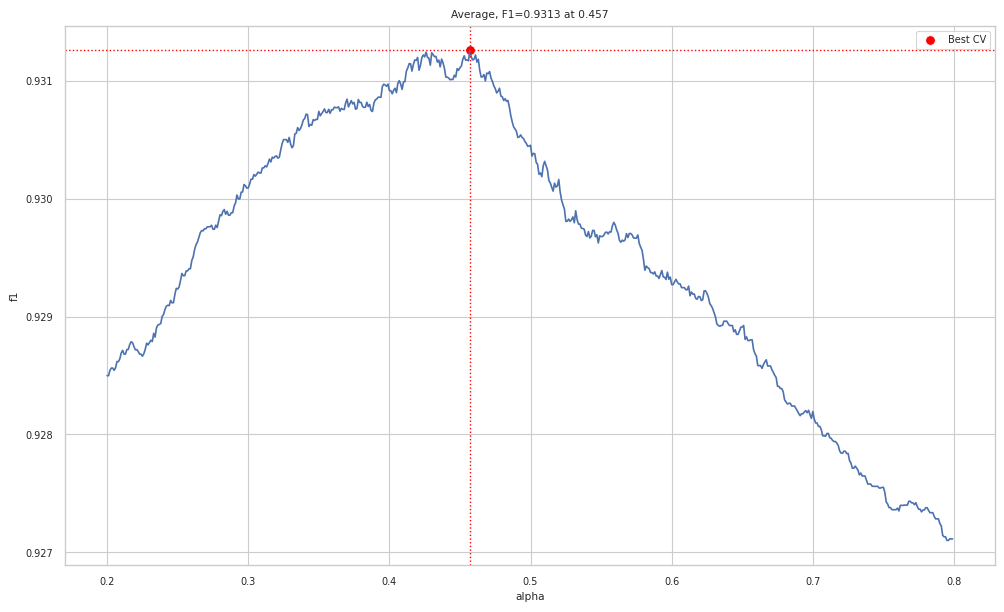

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
d = sns.lineplot(data=r, x="alpha", y="f1", ax=ax)
d = sns.scatterplot(x=[ALPHA], y=[BEST_CV], color="red", s=48, label='Best CV')
d = ax.axvline(ALPHA, color="red",  ls=':', lw=1)
d = ax.axhline(BEST_CV, color="red", ls=':', lw=1)
d = plt.title("Average, F1=%.4f at %.3f"%(BEST_CV, ALPHA))

### Final: Run OOF and ensemble on test data with the best weights

In [11]:
print("Generating submission for best CV=%.4f with ALPHA=%.3f" % (BEST_CV, ALPHA))
# Ensemble on OOF
ensemble_oof(MODELS_DICT)
ensemble_multiclass_pd, s = mc_ml_ensemble_oof(MODELS_DICT, alpha=ALPHA, inference_name=INFERENCE_NAME)
print("OOF F1 multi-classes and multi-labels ensemble=%.4f\n"%s)
# Same ensemble on Test
ensemble_test(MODELS_DICT, inference_name=INFERENCE_NAME)
folder = os.path.join(MODELS_HOME, "ensemble_final", "_".join(MODELS_DICT.keys()))
ensemble_multiclass_pd, submission_csv_pd = mc_ml_ensemble_test(MODELS_DICT, TEST_FILE, folder, alpha=ALPHA, inference_name=INFERENCE_NAME)
display(submission_csv_pd.head())

Generating submission for best CV=0.9313 with ALPHA=0.457
Loading: root_dir_mc_512/0.25 [('../models/RGB/timm_tf_efficientnetv2_m.in21k_512_None_v1.4.0-pl-crop-m16/stage2/seed42', None)] (52197, 47) F1=0.9182
Loading: root_dir_mc_224/0.25 [('../models/RGB/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.5-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]]), ('../models/RGB/timm_vit_large_patch16_224.augreg_in21k_ft_in1k_224_None_v1.2.4-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]]), ('../models/RGB/foundation_dinov2_vitb14_DinoBloom-B.pth_224_None_v1.4.0.6-pl-crop-m16/stage1/seed42', [[<function hflip at 0x7f549d1aea70>]])] (52197, 47) F1=0.9191
Loading: root_dir_mc_384/0.25 [('../models/RGB/timm_nextvit_large.bd_ssld_6m_in1k_384_384_None_v1.4.0-pl-crop-m16/stage2/seed42', [[<function hflip at 0x7f549d1aea70>]])] (52197, 47) F1=0.9165
Loading: root_dir_mc_tr_512/0.25 [('../models/RGB/timm_tiny_vit_21m_512.dist_in22k_ft_in1k_512_None_v1.

,trustii_id,NAME,x1,y1,x2,y2,class
0,43232,681daf42-3.jpg,116,116,248,242,LLC
1,65979,172bf8a5-e.jpg,100,96,229,269,Lysee
2,60083,179a21ee-4.jpg,102,94,273,278,PM
3,7302,f15e265d-6.jpg,101,99,261,267,M
4,31846,94cbe9cc-3.jpg,118,112,244,254,PNN
